2024-11-23 09:45:31,682 - INFO - 成功加载文件: data/login_logs.csv
2024-11-23 09:45:31,689 - INFO - 数据预处理完成
2024-11-23 09:45:31,761 - INFO - 异常检测模型构建完成
2024-11-23 09:45:31,761 - INFO - 规则已添加: 频繁登录失败 - 短时间内多次登录失败
2024-11-23 09:45:31,762 - INFO - 规则已添加: 同账号多地址登录 - 同一账号在短时间内从多个不同源地址登录
2024-11-23 09:45:31,762 - INFO - 规则已添加: 未知用户尝试 - 使用系统中不存在的用户尝试登录
2024-11-23 09:45:31,762 - INFO - 规则已添加: 非正常源地址登录 - 使用异常的源地址尝试登录
2024-11-23 09:45:31,762 - INFO - 正在应用规则: 频繁登录失败 (短时间内多次登录失败)
2024-11-23 09:45:31,764 - INFO - 正在应用规则: 同账号多地址登录 (同一账号在短时间内从多个不同源地址登录)
2024-11-23 09:45:31,765 - INFO - 正在应用规则: 未知用户尝试 (使用系统中不存在的用户尝试登录)
2024-11-23 09:45:31,765 - INFO - 正在应用规则: 非正常源地址登录 (使用异常的源地址尝试登录)
2024-11-23 09:45:31,776 - INFO - 规则 '频繁登录失败' 匹配数量: 1000 (100.00%)
2024-11-23 09:45:31,777 - INFO - 规则 '同账号多地址登录' 匹配数量: 483 (48.30%)
2024-11-23 09:45:31,777 - INFO - 规则 '未知用户尝试' 匹配数量: 96 (9.60%)
2024-11-23 09:45:31,777 - INFO - 规则 '非正常源地址登录' 匹配数量: 369 (36.90%)
2024-11-23 09:45:31,777 - INFO - 规则应用完成
2024-11-23 09:45:31,783 - INFO

1000
1000
1000
1000
1000


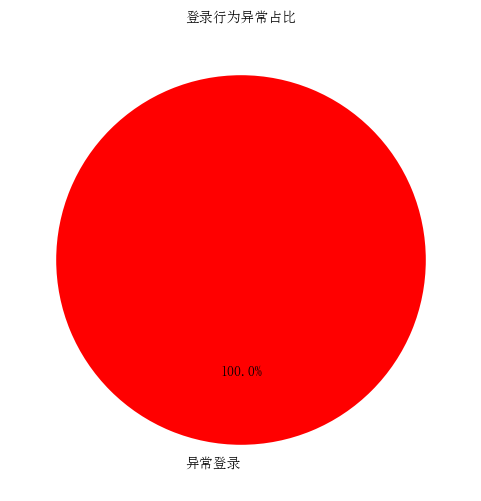


检测到的异常登录记录：
             用户ID           登录地址  登录失败次数  登录成功率      平均登录间隔  \
800  unknown_user    192.168.1.1      96    0.0  125.052632   
801  unknown_user  suspicious_ip      96    0.0  125.052632   
802  unknown_user    192.168.1.1      96    0.0  125.052632   
803  unknown_user    192.168.1.1      96    0.0  125.052632   
804  unknown_user      10.16.0.1      96    0.0  125.052632   
807  unknown_user    192.168.1.1      96    0.0  125.052632   
810  unknown_user  suspicious_ip      96    0.0  125.052632   
813  unknown_user    192.168.1.1      96    0.0  125.052632   
818  unknown_user    192.168.1.1      96    0.0  125.052632   
819  unknown_user    192.168.1.1      96    0.0  125.052632   

                         异常类型  
800            频繁登录失败, 未知用户尝试  
801  频繁登录失败, 未知用户尝试, 非正常源地址登录  
802            频繁登录失败, 未知用户尝试  
803            频繁登录失败, 未知用户尝试  
804            频繁登录失败, 未知用户尝试  
807            频繁登录失败, 未知用户尝试  
810  频繁登录失败, 未知用户尝试, 非正常源地址登录  
813            频繁登录失败, 未知用户尝试  
818  

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import ipaddress
import logging
from matplotlib import font_manager as fm

# 设置中文字体
font_path = "conf/simsun.ttc"
my_font = fm.FontProperties(fname=font_path)

# ------------------------------
# 设置日志
# ------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# ------------------------------
# 工具函数
# ------------------------------
def ip_in_subnet(ip, subnet):
    """
    检查 IP 是否属于指定网段
    """
    try:
        return ipaddress.ip_address(ip) in ipaddress.ip_network(subnet)
    except ValueError:
        return False

# ------------------------------
# 异常规则模块
# ------------------------------
class AnomalyRules:
    def __init__(self):
        """
        初始化异常规则管理
        """
        self.rules = []

    def add_rule(self, name, func, description=""):
        """
        添加新的异常规则
        """
        if not callable(func):
            raise ValueError(f"规则 {name} 的逻辑必须是一个可调用对象（函数）。")
        self.rules.append({"name": name, "func": func, "description": description})
        logging.info(f"规则已添加: {name} - {description}")

    def apply_rules(self, df):
        """
        应用所有规则并生成 '是否异常' 标记
        """
        results = {}
        for rule in self.rules:
            logging.info(f"正在应用规则: {rule['name']} ({rule['description']})")
            results[rule["name"]] = rule["func"](df)

        # 合并规则结果
        anomaly_flags = pd.DataFrame(results)
        df["规则异常"] = anomaly_flags.any(axis=1).astype(int)
        df["异常类型"] = anomaly_flags.apply(
            lambda row: ", ".join([name for name, val in row.items() if val]), axis=1
        )

        # 统计每个规则匹配的数量
        for rule_name, matches in results.items():
            match_count = matches.sum()
            match_ratio = match_count / len(df)
            logging.info(f"规则 '{rule_name}' 匹配数量: {match_count} ({match_ratio:.2%})")

        logging.info("规则应用完成")
        return df

# ------------------------------
# 数据加载与生成
# ------------------------------
def load_login_data(file_path="data/user_login_data.csv"):
    """
    加载指定文件中的用户登录数据，如果文件不存在则生成测试数据并返回
    """
    import os
    if os.path.exists(file_path):
        # 文件存在时，读取数据
        try:
            df = pd.read_csv(file_path, encoding="gbk")
            logging.info(f"成功加载文件: {file_path}")
        except Exception as e:
            logging.error(f"无法加载文件 {file_path}: {e}")
            raise
    else:
        # 文件不存在时，生成模拟测试数据
        logging.warning(f"文件 {file_path} 不存在，生成测试数据")
        user_ids = [f"user{i}" for i in range(1, 101)]
        data = {
            "用户ID": np.random.choice(user_ids, size=5000),
            "登录时间": pd.date_range("2024-11-01", periods=5000, freq="T"),
            "登录地址": np.random.choice(["192.168.1.1", "10.16.0.1", "172.16.0.1", "10.17.0.1", "203.0.113.1"], size=5000),
            "登录资源": np.random.choice(["server1", "server2"], size=5000),
            "是否登录成功": np.random.choice(["success", "failure"], size=5000, p=[0.7, 0.3]),
        }
        df = pd.DataFrame(data)

        # 添加模拟异常
        df.loc[np.random.choice(df.index, 100), "用户ID"] = "unknown_user"
        df.loc[np.random.choice(df.index, 100), "登录地址"] = "203.0.113.255"

        logging.info("模拟登录数据生成完成")
    
    return df

# ------------------------------
# 数据预处理
# ------------------------------
def preprocess_data(df):
    """
    数据清洗和特征提取
    """
    df["登录时间"] = pd.to_datetime(df["登录时间"], errors="coerce")

    # 添加登录是否成功的标志
    df["登录成功"] = df["是否登录成功"].apply(lambda x: 1 if x == "success" else 0)

    # 计算每个用户的登录失败次数、成功次数和成功率
    df["登录失败次数"] = df.groupby("用户ID")["登录成功"].transform(lambda x: (x == 0).sum())
    df["登录成功次数"] = df.groupby("用户ID")["登录成功"].transform(lambda x: (x == 1).sum())
    df["总登录次数"] = df.groupby("用户ID")["登录成功"].transform("count")
    df["登录成功率"] = df["登录成功次数"] / df["总登录次数"]

    # 计算每个用户的平均登录间隔
    df.sort_values(by=["用户ID", "登录时间"], inplace=True)
    df["时间差"] = df.groupby("用户ID")["登录时间"].diff().dt.total_seconds()
    df["平均登录间隔"] = df.groupby("用户ID")["时间差"].transform("mean").fillna(0)

    # 编码用户ID和地址
    encoder_user = LabelEncoder()
    df["用户编码"] = encoder_user.fit_transform(df["用户ID"])
    encoder_address = LabelEncoder()
    df["地址编码"] = encoder_address.fit_transform(df["登录地址"])

    logging.info("数据预处理完成")
    return df

# ------------------------------
# 异常登录检测模型构建
# ------------------------------
def build_detection_model(df):
    """
    使用Isolation Forest构建异常检测模型
    """
    features = ["登录失败次数", "登录成功率", "平均登录间隔"]
    X = df[features]

    # 训练Isolation Forest模型
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X)

    # 预测异常分数
    df["模型异常分数"] = model.decision_function(X)
    df["模型异常"] = model.predict(X)
    # -1表示异常，1表示正常

    logging.info("异常检测模型构建完成")
    return model, df

# ------------------------------
# 规则检测异常行为
# ------------------------------
def apply_anomaly_rules(df):
    """
    定义并应用异常规则
    """
    anomaly_rules = AnomalyRules()
    anomaly_rules.add_rule(
        "频繁登录失败",
        lambda x: x.groupby("用户ID")["登录成功"].transform(lambda s: s.rolling(window=5, min_periods=1).sum()) == 0,
        "短时间内多次登录失败"
    )
    anomaly_rules.add_rule(
        "同账号多地址登录",
        lambda x: x.groupby("用户ID")["登录地址"].transform("nunique") > 3,
        "同一账号在短时间内从多个不同源地址登录"
    )
    anomaly_rules.add_rule(
        "未知用户尝试",
        lambda x: x["用户ID"] == "unknown_user",
        "使用系统中不存在的用户尝试登录"
    )
    anomaly_rules.add_rule(
        "非正常源地址登录",
        lambda x: x["登录地址"].apply(lambda ip: not ip_in_subnet(ip, "192.168.0.0/16") and not ip_in_subnet(ip, "10.0.0.0/8")),
        "使用异常的源地址尝试登录"
    )

    df = anomaly_rules.apply_rules(df)
    return df

# ------------------------------
# 合并模型和规则的检测结果
# ------------------------------
def combine_anomaly_results(df):
    """
    合并模型和规则的异常检测结果
    """
    df["是否异常"] = df.apply(
        lambda row: 1 if row["模型异常"] == -1 or row["规则异常"] == 1 else 0, axis=1
    )
    logging.info("异常检测结果合并完成")
    return df

# ------------------------------
# 可视化异常数据
# ------------------------------
def visualize_anomalies(df):
    """
    绘制异常统计结果
    """
    anomaly_count = df["是否异常"].value_counts()
    labels = anomaly_count.index.map(lambda x: "异常登录" if x == 1 else "正常登录").tolist()

    plt.figure(figsize=(6, 6))
    plt.pie(
        anomaly_count,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=["red", "green"][:len(anomaly_count)],
        textprops={"fontproperties": my_font}  # 设置中文字体
    )
    plt.title("登录行为异常占比", fontproperties=my_font)
    plt.show()

    anomalies = df[df["是否异常"] == 1]
    print("\n检测到的异常登录记录：")
    print(anomalies[["用户ID", "登录地址", "登录失败次数", "登录成功率", "平均登录间隔", "异常类型"]].head(10))

# ------------------------------
# 主程序
# ------------------------------
if __name__ == "__main__":
    # 加载数据
    df = load_login_data(file_path="data/login_logs.csv")
    print(len(df))
    # 数据预处理
    df = preprocess_data(df)
    print(len(df))

    # 异常检测模型构建
    model, df = build_detection_model(df)
    print(len(df))

    # 应用规则检测异常
    df = apply_anomaly_rules(df)
    print(len(df))

    # 合并模型和规则的检测结果
    df = combine_anomaly_results(df)
    print(len(df))

    # 可视化异常数据
    visualize_anomalies(df)
